In [ ]:
# Import all required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lung-and-colon-cancer-histopathological-images


In [ ]:
dataset_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images"
lung_path = os.path.join(dataset_path, "lung_colon_image_set/lung_image_sets")

In [ ]:
classes = ['lung_aca', 'lung_scc', 'lung_n']  # Adenocarcinoma, Squamous, Benign
class_labels = ['Adenocarcinoma', 'Squamous', 'Benign']

In [ ]:
def visualize_samples():
    plt.figure(figsize=(15, 5))

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(lung_path, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:3]  # First 3 images

        for img_idx, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)

            plt.subplot(3, 3, class_idx*3 + img_idx + 1)
            plt.imshow(img)
            plt.title(f"{class_labels[class_idx]}\n{img.size[0]}x{img.size[1]}", fontsize=8)
            plt.axis('off')

    plt.suptitle("Lung Cancer Histopathology Samples", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

Visualizing dataset samples...


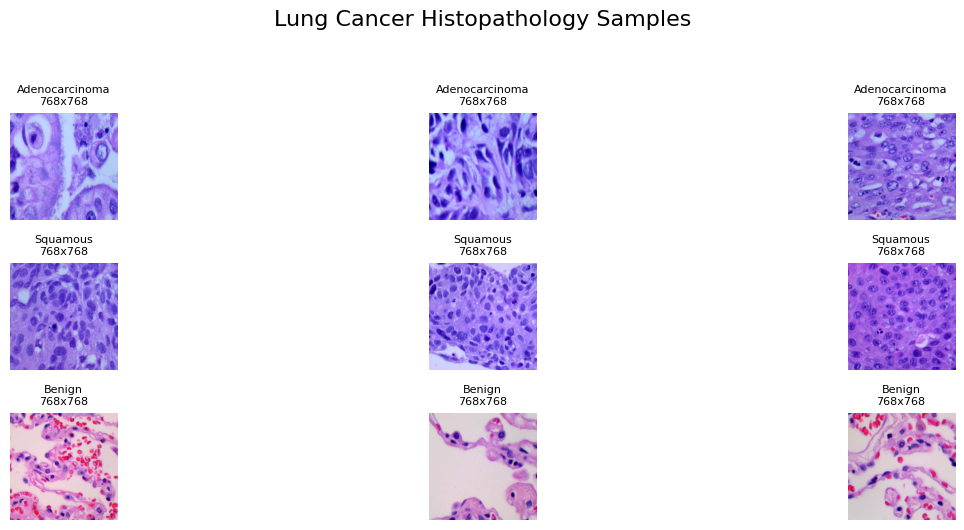

In [ ]:
print("Visualizing dataset samples...")
visualize_samples()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Original Keras model used 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for class_idx, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.image_paths.extend(images)
            self.labels.extend([class_idx] * len(images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
full_dataset = LungCancerDataset(lung_path, classes, transform=transform)


In [ ]:
train_idx, test_idx = train_test_split(
    range(len(full_dataset)),
    test_size=0.3,
    stratify=full_dataset.labels,
    random_state=42
)

val_idx, test_idx = train_test_split(
    test_idx,
    test_size=0.5,
    stratify=[full_dataset.labels[i] for i in test_idx],
    random_state=42
)

In [ ]:
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
print(f"\nDataset sizes:")
print(f"Training: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Testing: {len(test_dataset)} samples")


Dataset sizes:
Training: 10500 samples
Validation: 2250 samples
Testing: 2250 samples


In [ ]:
class LungCancerCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LungCancerCNN, self).__init__()

        # Feature extraction (matches original Keras model)
        self.features = nn.Sequential(
            # Conv1: 32 filters, 5x5 kernel, same padding
            nn.Conv2d(3, 32, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv2: 64 filters, 3x3 kernel, same padding
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv3: 128 filters, 3x3 kernel, same padding
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Classifier (matches original Keras model)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # After 3 maxpool(2,2), 224 -> 28
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LungCancerCNN(num_classes=len(classes)).to(device)

In [ ]:
criterion = CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss/len(loader), 100*correct/total

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (running_loss/len(loader),
            100*correct/total,
            all_preds,
            all_labels)

In [ ]:
num_epochs = 15
best_val_acc = 0.0

print("\nStarting training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print("  ↳ Saved new best model")



Starting training...
Epoch 1/15:
  Train Loss: 0.3655 | Acc: 86.14%
  Val Loss: 0.3913 | Acc: 83.87%
  ↳ Saved new best model
Epoch 2/15:
  Train Loss: 0.2368 | Acc: 92.26%
  Val Loss: 0.2320 | Acc: 91.69%
  ↳ Saved new best model
Epoch 3/15:
  Train Loss: 0.1805 | Acc: 94.22%
  Val Loss: 0.7031 | Acc: 78.53%
Epoch 4/15:
  Train Loss: 0.1469 | Acc: 95.81%
  Val Loss: 0.7425 | Acc: 70.80%
Epoch 5/15:
  Train Loss: 0.1335 | Acc: 96.32%
  Val Loss: 0.5097 | Acc: 77.29%
Epoch 6/15:
  Train Loss: 0.1029 | Acc: 97.82%
  Val Loss: 0.1750 | Acc: 93.96%
  ↳ Saved new best model
Epoch 7/15:
  Train Loss: 0.0928 | Acc: 98.34%
  Val Loss: 0.2156 | Acc: 91.60%
Epoch 8/15:
  Train Loss: 0.0818 | Acc: 98.63%
  Val Loss: 0.1700 | Acc: 94.44%
  ↳ Saved new best model
Epoch 9/15:
  Train Loss: 0.0801 | Acc: 98.57%
  Val Loss: 0.1618 | Acc: 94.31%
Epoch 10/15:
  Train Loss: 0.0738 | Acc: 98.91%
  Val Loss: 0.1978 | Acc: 92.58%
Epoch 11/15:
  Train Loss: 0.0708 | Acc: 98.99%
  Val Loss: 0.1579 | Acc: 94.

In [ ]:
model.load_state_dict(torch.load('best_cnn_model.pth'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"\nFinal Test Performance:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")


Final Test Performance:
Loss: 0.1623 | Accuracy: 94.22%


In [ ]:
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_labels))




Classification Report:
                precision    recall  f1-score   support

Adenocarcinoma       0.94      0.89      0.91       750
      Squamous       0.90      0.94      0.92       750
        Benign       0.99      1.00      0.99       750

      accuracy                           0.94      2250
     macro avg       0.94      0.94      0.94      2250
  weighted avg       0.94      0.94      0.94      2250



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

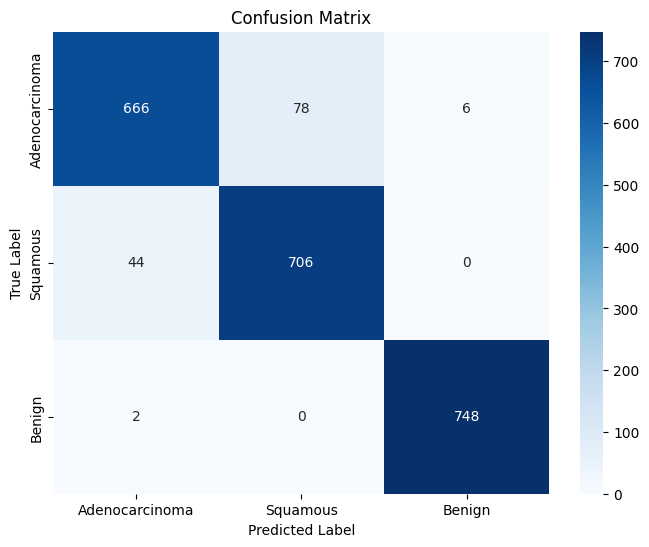

In [ ]:
plot_confusion_matrix(test_labels, test_preds, class_labels)

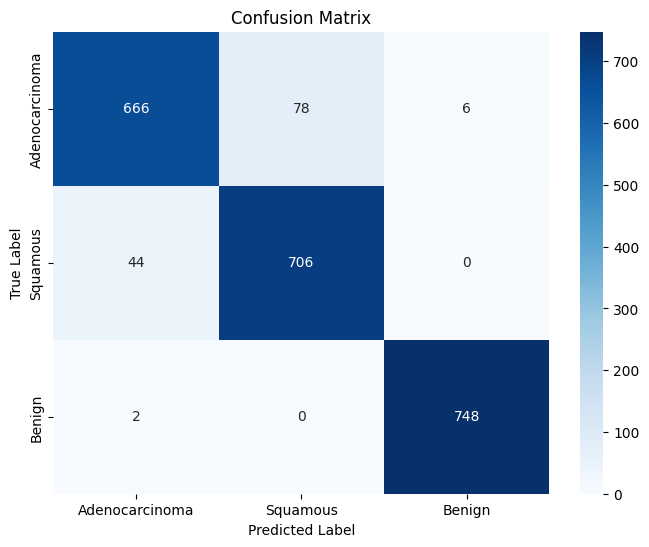

In [ ]:
plot_confusion_matrix(test_labels, test_preds, class_labels)

In [ ]:
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()

LungCancerCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)

In [ ]:
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(test_labels, test_preds, target_names=class_labels))


Classification Report:
                precision    recall  f1-score   support

Adenocarcinoma       0.94      0.89      0.91       750
      Squamous       0.90      0.94      0.92       750
        Benign       0.99      1.00      0.99       750

      accuracy                           0.94      2250
     macro avg       0.94      0.94      0.94      2250
  weighted avg       0.94      0.94      0.94      2250



In [ ]:
def plot_enhanced_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                annot_kws={"size": 14}, cbar=False)

    # Add percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.5, f"{cm_norm[i,j]*100:.1f}%",
                    ha='center', va='center', color='red', fontsize=12)

    plt.title('Enhanced Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=0)
    plt.show()


Enhanced Confusion Matrix:


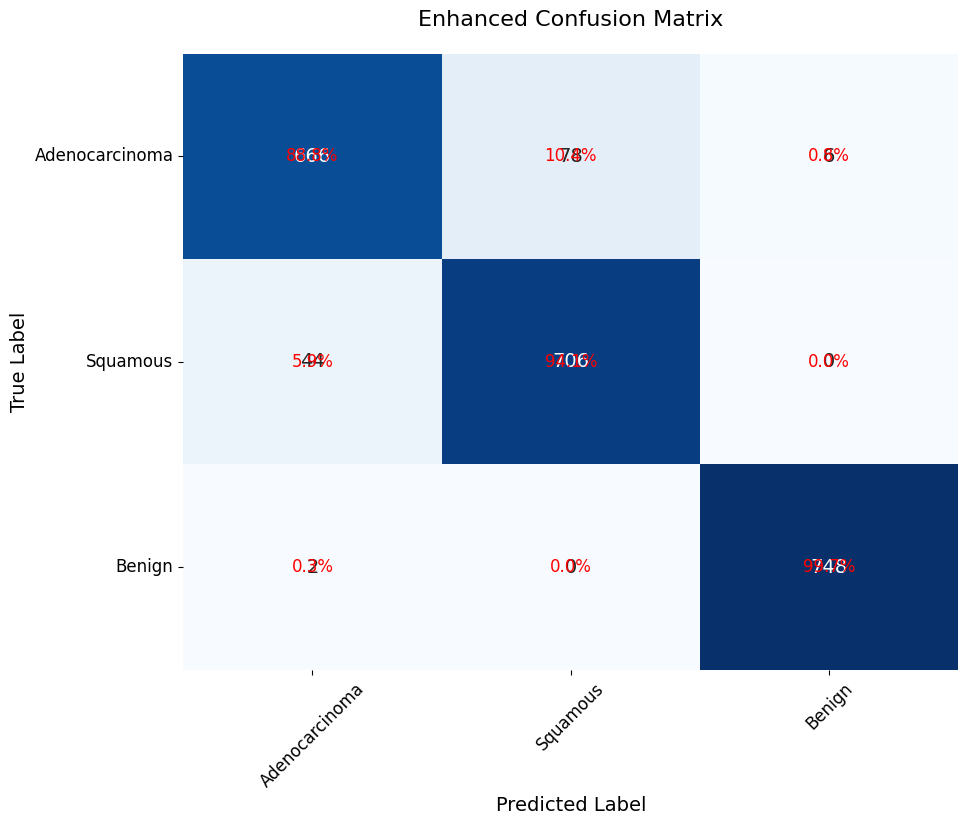

In [ ]:
print("\n\033[1mEnhanced Confusion Matrix:\033[0m")
plot_enhanced_confusion_matrix(test_labels, test_preds, class_labels)

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

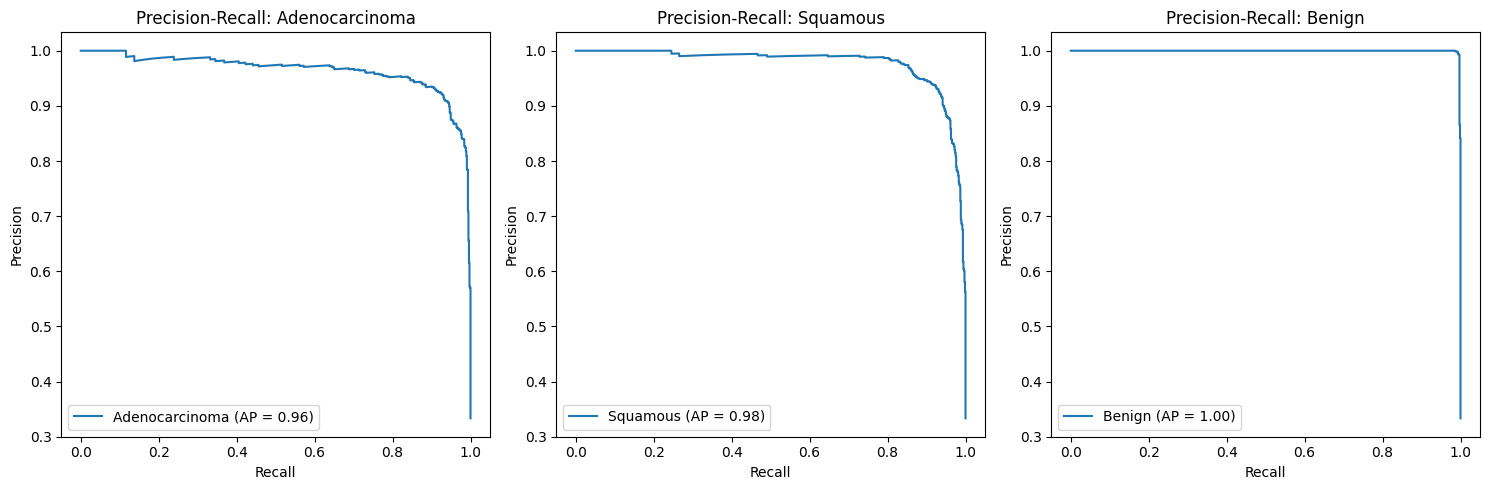

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# %%
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(class_labels):
    y_true_class = (np.array(test_labels) == i).astype(int)

    # Process test set in batches and collect scores on CPU
    all_scores = []
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            scores = torch.softmax(outputs, 1).cpu().numpy() # Move scores to CPU immediately
            all_scores.append(scores)

    # Concatenate scores from all batches
    y_score = np.concatenate(all_scores, axis=0)[:, i]

    precision, recall, _ = precision_recall_curve(y_true_class, y_score)
    ap = average_precision_score(y_true_class, y_score)

    plt.subplot(1, 3, i+1)
    plt.plot(recall, precision, label=f'{class_name} (AP = {ap:.2f})')
    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.title(f'Precision-Recall: {class_name}', fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()

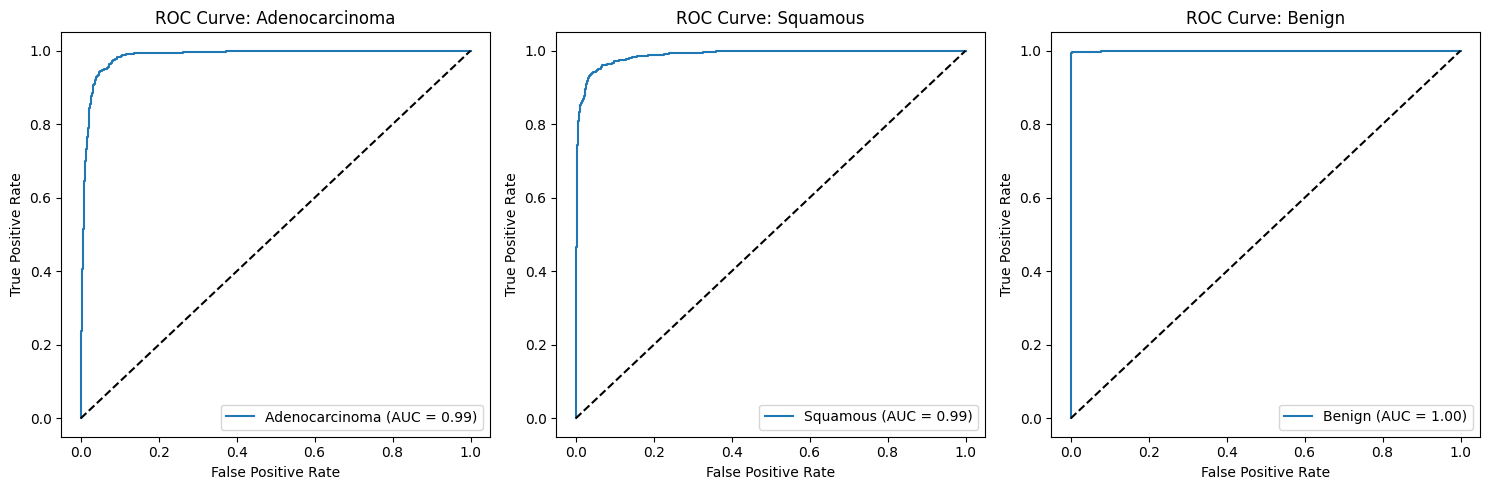

In [ ]:
from sklearn.metrics import roc_curve, auc
import torch # Ensure torch is imported if not already

plt.figure(figsize=(15, 5))
for i, class_name in enumerate(class_labels):
    y_true_class = (np.array(test_labels) == i).astype(int)

    # Process test set in batches and collect scores on CPU
    all_scores = []
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Move scores to CPU immediately after getting outputs
            scores = torch.softmax(outputs, 1).cpu().numpy()
            all_scores.append(scores)

    # Concatenate scores from all batches on the CPU
    y_score = np.concatenate(all_scores, axis=0)[:, i]

    # Rest of the ROC curve calculation remains the same
    fpr, tpr, _ = roc_curve(y_true_class, y_score)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 3, i+1)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(f'ROC Curve: {class_name}', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def show_misclassified_examples(num_examples=5):
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(),
                                        labels[i].cpu(),
                                        preds[i].cpu()))
                    if len(misclassified) >= num_examples:
                        break
            if len(misclassified) >= num_examples:
                break

    plt.figure(figsize=(15, 3))
    plt.suptitle('Top Misclassified Examples', fontsize=16)
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_examples, i+1)
        plt.imshow(img)
        plt.title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Misclassified Examples:


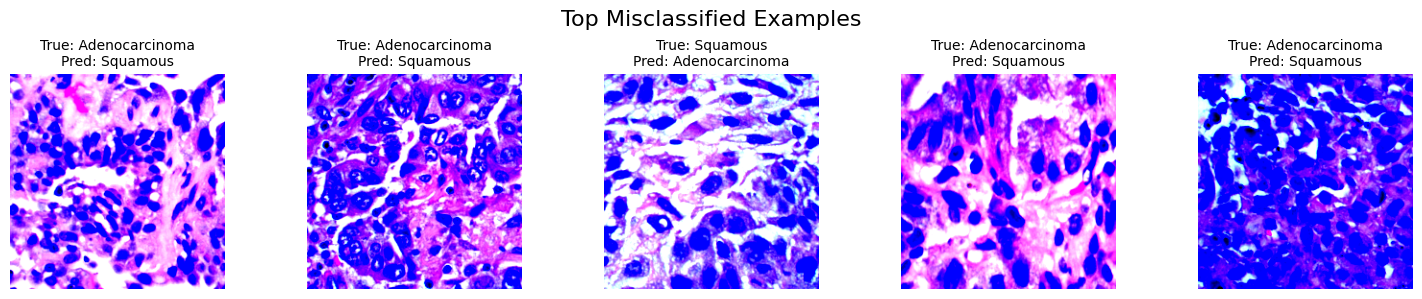

In [ ]:
print("\n\033[1mMisclassified Examples:\033[0m")
show_misclassified_examples()